In [1]:
import pandas as pd
from pandas import rolling_median
import numpy as np
import matplotlib.pyplot as plt

import helpers

# Manipulando Dados

O objetivo da atividade é exercitar a manipulação e preprocessamento de uma base de dados e utiliza-la num algoritmo de aprendizagem de máquina, como exemplo é utilizada a base de dados de passageiros do Titanic.


## Leitura dos dados

In [15]:
df = pd.read_excel('dataset/titanic3.xls', sheet_name="titanic3")

print(len(df))

df[:10]

1309


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay"


## 1 - Pré-processamento dos dados

Foram aplicados alguns passo de pré-processamento dos dados que são descutidos a seguir

## 1.5 - Identificação e remoção de valores discrepantes

Nesse passo são verificados os dados da coluna 'Fare' a fim de identificar dados com valores discrepantes em relação aos demais. São utilizadas a média e o desvio padrão dos dados para a indeficação dos valores discrepantes 

### Distribuição dos dados antes da remoção dos valores discrepantes 

1308

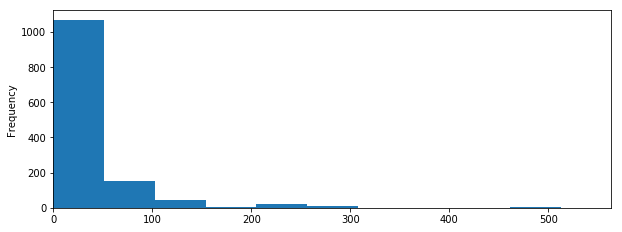

In [16]:
df = helpers.drop_nan_row(df, 'fare')
helpers.plot_dist(df, 'fare', 'hist')

len(df)

### Distribuição dos dados após a remoção dos valores discrepantes

1254

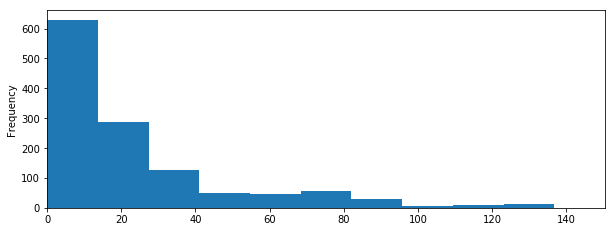

In [17]:
df = helpers.remove_outliers(df, "fare", 2)

helpers.plot_dist(df, 'fare', 'hist')

len(df)

## 1.2 Remoção de atributos

Alguns atributos dos dados foram desconsiderados, como: 'Name', 'Ticket', 'Cabin', entre outros, por conterem informações que consideramos desnecessárias ou por muitas informações inexistentes. 

## 1.3 Substituição de dados faltantes

Alguns dados possuem apenas alguns atributos com valor inexistente, por exemplo, apenas algumas linha não possuem o atributo 'Age', nesses casos foram atribuídos a média dos valores de todo o conjunto de dadosções

## 1.4 Conversão de dados

Algumas informações não estão em valor numérico, como 'Name' e 'Embarked', nesses casos, a strings foram consideradas como classes e essas classes foram utilizadas no lugar do valor original, por exemplo, os valore 'male' e 'female' são subistituídas pelos valores 0 e 1, respectivamente, que representam as 'classes' dos valores.

## 1.5 Normalização de dados

Atributos como 'Age' e 'Fate' possuem uma grande variação de valores, o que pode dificultar que o algoritmo de apredizagem aprenda os dados. Para sanar isso, os valores desses atributos foram normalizados para que apenas variem entre 0 e 1.

In [18]:
df = helpers.titanic_preprocessing_pipeline(df)

print(len(df))

df[:10]

1252


,pclass,survived,sex,age,sibsp,parch,fare,embarked
5,1,1,1,0.599165,0,0,0.194108,2
6,1,1,0,0.787056,1,0,0.569957,2
7,1,0,1,0.486430,0,0,0.000000,2
8,1,1,0,0.661795,2,0,0.376367,2
9,1,0,1,0.887265,0,0,0.361928,0
12,1,1,0,0.298538,0,0,0.506656,0
13,1,1,0,0.323591,0,0,0.576477,2
14,1,1,1,1.000000,0,0,0.219332,2
15,1,0,1,0.361169,0,0,0.189539,2
18,1,1,0,0.398747,0,0,0.557773,0


## 2 - Correlação dos dados

Abaixo é apresentada a matriz de correlação dos atributos, isso é feito para se buscar por atributos com correlações fortes afim de eliminar um deles.

Na matriz de correlações dos dados trabalhados, a maior correção, em módulo, é entre 'Pclass' e 'Fate', com um correlação de aproximadamente '-0.65', o que não consideramos uma correlação suficientemente forte para eliminar um dos atributos.

In [19]:
df.corr(method='pearson', min_periods=1)

,pclass,survived,sex,age,sibsp,parch,fare,embarked
pclass,1.000000,-0.294040,0.087586,-0.369937,0.077264,0.070157,-0.656415,0.161295
survived,-0.294040,1.000000,-0.511630,-0.057829,-0.030501,0.077415,0.277444,-0.168424
sex,0.087586,-0.511630,1.000000,0.073284,-0.112299,-0.217701,-0.187746,0.095500
age,-0.369937,-0.057829,0.073284,1.000000,-0.194380,-0.152810,0.170155,-0.055597
sibsp,0.077264,-0.030501,-0.112299,-0.194380,1.000000,0.366674,0.278721,0.068357
parch,0.070157,0.077415,-0.217701,-0.152810,0.366674,1.000000,0.225984,0.055984
fare,-0.656415,0.277444,-0.187746,0.170155,0.278721,0.225984,1.000000,-0.223330
embarked,0.161295,-0.168424,0.095500,-0.055597,0.068357,0.055984,-0.223330,1.000000


## 3 Utilizando os dados no treinamento

In [20]:
data_train = df.copy(deep=True)

data_test = pd.read_csv('dataset/test.csv')
data_test.columns = [x.lower() for x in data_test.columns]
data_test = helpers.titanic_preprocessing_pipeline(data_test)

In [23]:
y_train = data_train['survived'].values
data_train.drop(['survived'], axis=1)
x_train = data_train.values

#y_test = data_train['survived'].values
#data_teste.drop(['survived'], axis=1)
x_test = data_test.values